In [25]:

#This is Machine Learning
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
import pathlib
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import models, layers
import keras.utils as image
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import img_to_array, load_img

#This is used to import the data
import glob
import os
from os import listdir
import requests
from zipfile import ZipFile

# Potato
import random
random.seed(0)

# small visualization
from IPython.display import display, Image

In [2]:
# Stole this from homework 8
def plot_metric(history, metric='loss'):
    """ Plot training and test values for a metric. """
    val_metric = 'val_'+metric
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show();

Data Importing

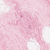

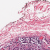

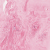

In [3]:
#Got this from ChatGPT

# Define the GitHub repository URL
repo_url = 'https://github.com/StevenHPatrick/breastCancerData/archive/94de9300f0851b14430654cd36089af864e6017b.zip'

# Specify the local path to save the downloaded file
zip_file_path = 'breast_cancer_data.zip'

# Specify the target directory
output_dir = 'breast_cancer_data'

# Check if the target directory already exists
if not os.path.exists(output_dir):
    # Download the dataset from GitHub
    response = requests.get(repo_url)
    with open(zip_file_path, 'wb') as zip_file:
        zip_file.write(response.content)

    # Extract the contents of the ZIP file
    extracted_path = 'breastCancerData-94de9300f0851b14430654cd36089af864e6017b'
    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

    # Adjust the path to include the additional subdirectory
    dataset_path = os.path.join(extracted_path, 'breastCancerData-94de9300f0851b14430654cd36089af864e6017b')

    # Create the 'breast_cancer_data' directory
    os.makedirs(output_dir)

    # Move the contents to 'breast_cancer_data' directory
    for item in os.listdir(dataset_path):
        s = os.path.join(dataset_path, item)
        d = os.path.join(output_dir, item)
        os.rename(s, d)

# Now, breast_img will contain the paths to the images in 'breast_cancer_data'
breast_img = glob.glob(os.path.join(output_dir, 'archive/IDC_regular_ps50_idx5/**/*.png'), recursive=True)

# Display the first 3 images
for img_path in breast_img[:3]:
    display(Image(filename=img_path))


In [4]:
non_img = []
can_img = []

for img in breast_img:
    if img[-5] == '0' :
        non_img.append(img)

    elif img[-5] == '1' :
        can_img.append(img)
breast_img[0]

'breast_cancer_data/archive/IDC_regular_ps50_idx5/9254/0/9254_idx5_x901_y701_class0.png'

Data Discovery

In [5]:
patients = [len(non_img), len(can_img)]

total_img_num = patients[0] + patients[1]

print('Number of benign patients: {}' .format(patients[0]))
print('Number of malignant patients: {}' .format(patients[1]))
print('Total Number of Images : {}' .format(total_img_num))

Number of benign patients: 198738
Number of malignant patients: 78786
Total Number of Images : 277524


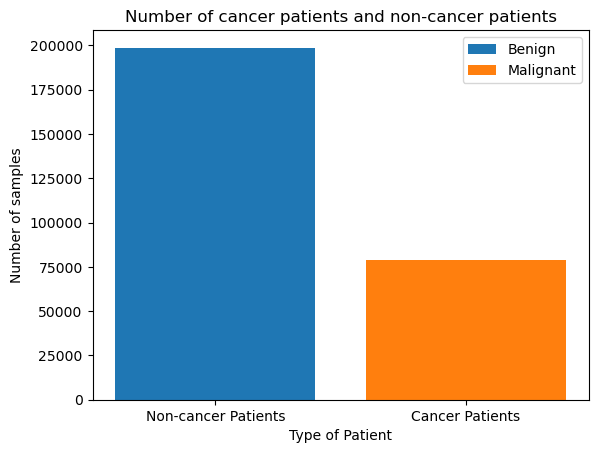

In [6]:
#Written by Steven and only Steven
plt.bar("Non-cancer Patients", patients[0], label = 'Benign')
plt.bar("Cancer Patients", patients[1], label = 'Malignant')
plt.ylabel("Number of samples")
plt.xlabel("Type of Patient")
plt.title("Number of cancer patients and non-cancer patients")
plt.legend()
plt.show();

277534 images is a lot to train on. We decided to reduce the number of images we are training on.

In [7]:
non_img = np.array(non_img)
can_img = np.array(can_img)

# Generate random indices
fivek_no_cancer_indices = np.random.randint(0, len(non_img), 5000)
fivek_cancer_indices = np.random.randint(0, len(can_img), 5000)

# Use boolean indexing to copy the selected images
fivek_no_cancer = non_img[fivek_no_cancer_indices]
fivek_cancer = can_img[fivek_cancer_indices]

In [8]:
patients = [len(fivek_no_cancer), len(fivek_cancer)]

total_img_num = patients[0] + patients[1]

print('Number of benign patients: {}' .format(patients[0]))
print('Number of malignant patients: {}' .format(patients[1]))
print('Total Number of Images : {}' .format(total_img_num))

Number of benign patients: 5000
Number of malignant patients: 5000
Total Number of Images : 10000


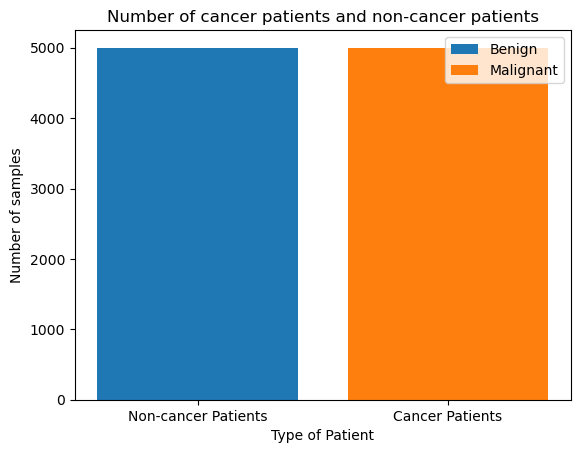

In [9]:
#Written by Steven and only Steven
plt.bar("Non-cancer Patients", patients[0], label = 'Benign')
plt.bar("Cancer Patients", patients[1], label = 'Malignant')
plt.ylabel("Number of samples")
plt.xlabel("Type of Patient")
plt.title("Number of cancer patients and non-cancer patients")
plt.legend()
plt.show();

This is a more managable size to start training on. We will look at increasing the dataset later one.

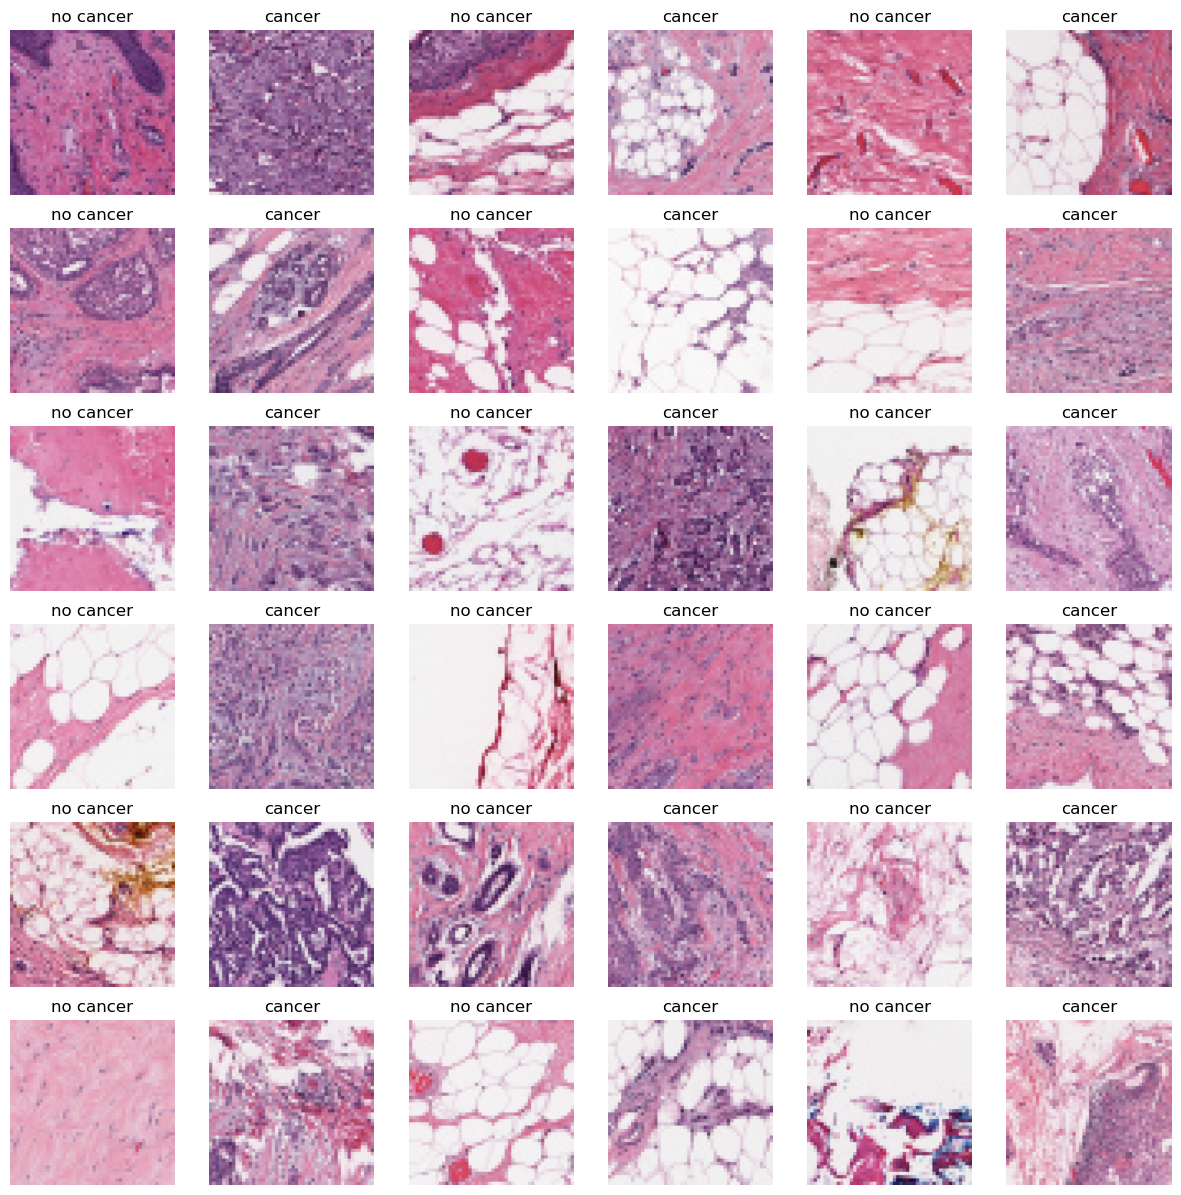

In [10]:
#Took this code from a kaggle notebook because it looked too cool. Also, it confirms that 

plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(fivek_no_cancer), 18)
some_can = np.random.randint(0, len(fivek_cancer), 18)

s = 0
for num in some_non:
    
        img = image.load_img((fivek_no_cancer[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1

s = 1
for num in some_can:
    
        img = image.load_img((fivek_cancer[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
plt.show()


Preprocess data and concatenate

In [11]:
def preprocess_images(image_paths, target_size=(100, 100)):
    """Normalize and resize images"""
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalize pixel values to the range [0, 1]. This is important later on when I test to see what the label is from a random X_test
        images.append(img_array)
    return np.array(images)

In [12]:
# Preprocess no cancer images
fivek_no_cancer_images = preprocess_images(fivek_no_cancer)

# Preprocess cancer images
fivek_cancer_images = preprocess_images(fivek_cancer)

# Combine the datasets
X = np.concatenate([fivek_no_cancer_images, fivek_cancer_images])

# Create labels for the dataset (0 for no cancer, 1 for cancer). This information was obtained from looking through the Kaggle's discussions 
y = np.concatenate([np.zeros(len(fivek_no_cancer_images)), np.ones(len(fivek_cancer_images))])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8000, 100, 100, 3)
X_test shape: (2000, 100, 100, 3)
y_train shape: (8000,)
y_test shape: (2000,)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856 

2023-12-05 22:46:17.018850: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/50
250/250 [==============================] - 47s 185ms/step - loss: 0.5905 - accuracy: 0.6867 - val_loss: 0.4969 - val_accuracy: 0.7670
Epoch 2/50
250/250 [==============================] - 39s 154ms/step - loss: 0.4993 - accuracy: 0.7778 - val_loss: 0.4945 - val_accuracy: 0.7685
Epoch 3/50
250/250 [==============================] - 37s 147ms/step - loss: 0.4830 - accuracy: 0.7839 - val_loss: 0.4455 - val_accuracy: 0.8110
Epoch 4/50
250/250 [==============================] - 37s 147ms/step - loss: 0.4666 - accuracy: 0.7929 - val_loss: 0.4423 - val_accuracy: 0.8050
Epoch 5/50
250/250 [==============================] - 37s 147ms/step - loss: 0.4638 - accuracy: 0.7950 - val_loss: 0.4364 - val_accuracy: 0.8160
Epoch 6/50
250/250 [==============================] - 37s 148ms/step - loss: 0.4538 - accuracy: 0.8014 - val_loss: 0.4236 - val_accuracy: 0.8235
Epoch 7/50
250/250 [==============================] - 38s 153ms/step - loss: 0.4609 - accuracy: 0.7996 - val_loss: 0.4315 - val_ac

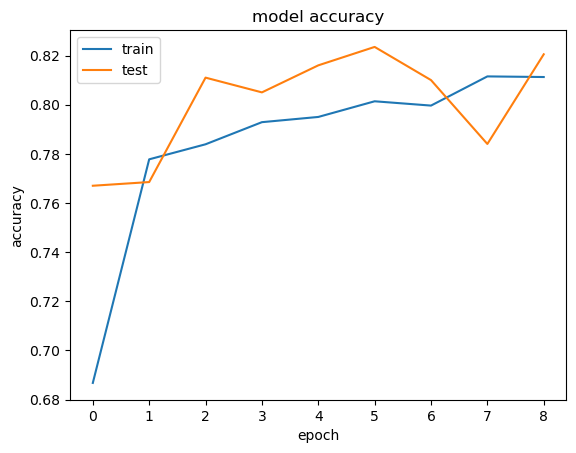

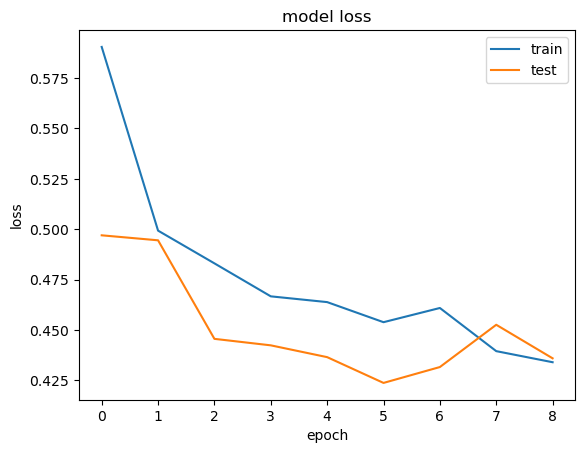

In [14]:
# Input layer
input_layer = layers.Input(shape=(100, 100, 3))

# Convolutional layers
conv1 = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
pool1 = layers.MaxPooling2D((2, 2))(conv1)
conv2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = layers.MaxPooling2D((2, 2))(conv2)
conv3 = layers.Conv2D(128, (3, 3), activation='relu')(pool2)
pool3 = layers.MaxPooling2D((2, 2))(conv3)

# Flatten the output
flatten = layers.Flatten()(pool3)

# Dense layers
dense1 = layers.Dense(128, activation='relu')(flatten)
dropout = layers.Dropout(0.5)(dense1)  # Dropout layer to reduce overfitting
output_layer = layers.Dense(1, activation='sigmoid')(dropout)  # Output layer with sigmoid activation for binary classification

# Create the model
model = models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping with patience
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Display the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Plot training history
plot_metric(history, 'accuracy')
plot_metric(history, 'loss')

In [15]:
# # I got worried that the model was not running with the correct label so this was a test to see how everything was working. I am happy to say,
# # everything is working how it should.

# # Select a random image from the test set
# random_index = np.random.randint(0, len(X_test))
# random_image = X_test[random_index]
# random_label = y_test[random_index]

# # Reshape the image to match the model's input shape
# random_image = np.expand_dims(random_image, axis=0)

# # Make a prediction using the trained model
# prediction = model.predict(random_image)

# # Convert the prediction to a binary label (0 or 1)
# predicted_label = 1 if prediction > 0.5 else 0

# # Display the actual label and the predicted label
# print(f"Actual Label: {random_label}")
# print(f"Predicted Label: {predicted_label}")

1/1 [==============================] - 0s 12ms/step


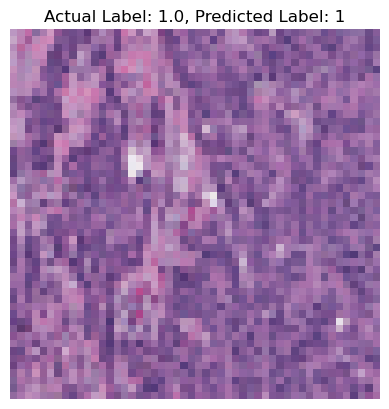

In [21]:
# I got worried that the model was not running with the correct label so this was a test to see how everything was working. I am happy to say,
# everything is working how it should.

# Select a random image from the test set
random_index = np.random.randint(0, len(X_test))
random_image = X_test[random_index]
random_label = y_test[random_index]

# Reshape the image to match the model's input shape
random_image_reshaped = np.expand_dims(random_image, axis=0)

# Make a prediction using the trained model
prediction = model.predict(random_image_reshaped)

# Convert the prediction to a binary label (0 or 1)
predicted_label = 1 if prediction > 0.5 else 0

# Reshape the original image for visualization
random_image = random_image * 255.0  # Reverse the normalization
random_image = random_image.astype(np.uint8)  # Convert to integer values

# Display the image with the actual and predicted labels as the title
plt.imshow(random_image)
plt.axis('off')
plt.title(f"Actual Label: {random_label}, Predicted Label: {predicted_label}")
plt.show()

In [23]:
keras.backend.clear_session()

In [ ]:
# Input layer
input_layer = layers.Input(shape=(100, 100, 3))
# x = data_augmentation(input_layer)

conv1 = layers.Conv2D(128, (3, 3), padding='same', use_bias=False)(input_layer)
batch1 = layers.BatchNormalization()(conv1)
x = layers.Activation('relu')(batch1)
pool1 = layers.MaxPooling2D((2, 2))(x)

conv2 = layers.Conv2D(128, (3, 3), padding='same',use_bias=False)(pool1)
batch2 = layers.BatchNormalization()(conv2)
x = layers.Activation('relu')(batch2)
pool2 = layers.MaxPooling2D((2, 2))(x)

conv3 = layers.Conv2D(128, (3, 3), padding='same',use_bias=False)(pool2)
batch3 = layers.BatchNormalization()(conv3)
x = layers.Activation('relu')(batch3)
pool3 = layers.MaxPooling2D((2, 2))(x)


x = layers.GlobalAveragePooling2D()(pool3)

# Dense layers
dense1 = layers.Dense(128, activation='relu')(x)
dropout = layers.Dropout(0.3)(dense1)
output_layer = layers.Dense(1, activation='sigmoid')(dropout)  # Output layer with sigmoid activation for binary classification

# Create the model
model = models.Model(inputs=input_layer, outputs=output_layer)


# Compile the model
model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.000001,verbose=1)

model.summary()

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping,reduce_lr])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 128)     3456      
                                                                 
 batch_normalization_3 (Batc  (None, 100, 100, 128)    512       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 100, 100, 128)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 128)       1474